In [1]:
import os
os.path

from datetime import datetime, timedelta
import cmocean

import pyproj
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import trajan as ta
import pandas as pd

import opendrift
from opendrift.models.leeway import Leeway
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.physics_methods import wind_drift_factor_from_trajectory, distance_between_trajectories, skillscore_liu_weissberg

import cartopy.crs as ccrs
from matplotlib.lines import Line2D

from scipy.spatial import ConvexHull, convex_hull_plot_2d

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
from matplotlib.lines import Line2D

In [79]:
d03 = xr.open_dataset('C:/Users/bente/Documents/BACKTRACK/backtracking/data/OO-2023.nc')       # all drifter data
d03 = d03.traj.gridtime('1H')
d03 = d03.isel(trajectory=0)             # drifter OO-2023-03

In [141]:
startlat = d03.lat.sel(time=slice(datetime(2023, 1, 15, 3, 12, 8), datetime(2023, 1, 15, 4, 12, 8))).values
startlon = d03.lon.sel(time=slice(datetime(2023, 1, 15, 3, 12, 8), datetime(2023, 1, 15, 4, 12, 8))).values

In [143]:
startlon

array([23.65147604])

In [144]:
len(hits[0])

30

In [145]:
orev = Leeway(loglevel=50)

In [146]:
orev

Model:	Leeway     (OpenDrift version 1.11.2)
	0 active LeewayObj particles  (0 deactivated, 0 scheduled)
-------------------
Environment variables:
  -----
Readers not added for the following variables:
  land_binary_mask
  x_sea_water_velocity
  x_wind
  y_sea_water_velocity
  y_wind

Discarded readers:

In [147]:
reader_globcur = reader_netCDF_CF_generic.Reader("C:/Users/bente/Documents/THESIS/Globcurrent/*.nc")
reader_wind = reader_netCDF_CF_generic.Reader('C:/Users/bente/Documents/THESIS/Globcurrent/Simulations_24h/OO-2023-03/agulhas_wind_2023.nc',
        standard_name_mapping={'u10': 'x_wind',
                               'v10': 'y_wind'})

object_type = 23  # Life-raft, shallow ballast system AND canopy, capsized

In [148]:
duration = timedelta(hours=120)                # 5 days
start_time = datetime(2023,1,10,3,12,8)
end_time = start_time + duration

In [184]:
outfile_bwd = "D:/backtrack/oceandrift_48h/likelihood/lw_bwd1015jan_nodif_raft_capsize_endloc.nc"

In [185]:
lonend1 = np.array(lonend0)
latend1 = np.array(latend0)

In [186]:
lonend = lonend1[~np.isnan(lonend0)]
latend = latend1[~np.isnan(latend0)]

In [187]:
orev = Leeway(loglevel=50)
orev.add_reader([reader_globcur, reader_wind])

orev.set_config('drift:advection_scheme', 'runge-kutta4')
orev.set_config('environment:fallback:x_sea_water_velocity', 0)
orev.set_config('environment:fallback:y_sea_water_velocity', 0)

orev.set_config('capsizing', True)
orev.set_config('capsizing:wind_threshold', 20)
orev.set_config('capsizing:wind_threshold_sigma', 5)
orev.set_config('capsizing:leeway_fraction', 0.4)  # Reducing leeway coefficients to 40% of original after capsize

#orev.set_config('drift:horizontal_diffusivity', 20)
orev.seed_elements(lon=lonend, lat=latend, radius=10000, radius_type='uniform', time=end_time, object_type=object_type)
orev.run(duration=duration, time_step=-900, time_step_output=3600, outfile=outfile_bwd)

In [188]:
back_capsize2 = xr.open_dataset(outfile_bwd)

In [10]:
# diflon = np.max(back.isel(time=48).lon.values) - np.min(back.isel(time=48).lon.values)
# diflat = np.max(back.isel(time=48).lat.values) - np.min(back.isel(time=48).lat.values)

In [11]:
end_time

datetime.datetime(2023, 1, 15, 3, 12, 8)

In [12]:
# # Define domain of possible origin !!! WITH RANDOM UNIFORM SEEDING !!!
# lons = np.zeros((120,120))
# lats = np.zeros((120,120))
# for j in range(120):
#     lons[j] = np.random.uniform(np.min(back.isel(time=48).lon.values)-(0.5), np.max(back.isel(time=48).lon.values)+(0.5), 120) # Much coarser CCC
#     lats[j] = np.random.uniform(np.min(back.isel(time=48).lat.values)-(0.5), np.max(back.isel(time=48).lat.values)+(0.5), 120)

In [13]:
backlon = back.isel(time=120).lon.values[back.isel(time=120).lon.values<10e5]
backlat = back.isel(time=120).lat.values[back.isel(time=120).lat.values<0]

In [14]:
# Set the desired grid size
grid_size_lon = 0.360  # Change this to your desired grid size
grid_size_lat = 0.300

# Calculate the number of grid cells in each dimension
lon_bins = np.arange(np.min(backlon)-(0.5), np.max(backlon)+(0.5), grid_size_lon)
lat_bins = np.arange(np.min(backlat)-(0.5), np.max(backlat)+(0.5), grid_size_lat)

In [15]:
binmesh = np.meshgrid(lon_bins, lat_bins)

In [16]:
lons = np.zeros((len(lon_bins)-1,(len(lat_bins)*100)-100))
lats = np.zeros((len(lon_bins)-1,(len(lat_bins)*100)-100))
for i in range(len(binmesh[0][0])-1):
    for j in range(len(binmesh[1])-1):
        lons[i][(j*100):((j+1)*100)] = np.random.uniform(binmesh[0][0][i], binmesh[0][0][i+1], 100) # Much coarser CCC
        lats[i][(j*100):((j+1)*100)] = np.random.uniform(binmesh[1][j][0], binmesh[1][j+1][0], 100)

# FWD

In [44]:
outfile = "D:/backtrack/oceandrift_48h/likelihood/lw_fwd1015jan_nodif_raft_capsize20.nc"

In [ ]:
ofwd = Leeway(loglevel=0)
ofwd.add_reader([reader_globcur, reader_wind])
ofwd.set_config('drift:advection_scheme', 'runge-kutta4')

ofwd.set_config('environment:fallback:x_sea_water_velocity', 0)
ofwd.set_config('environment:fallback:y_sea_water_velocity', 0)

ofwd.set_config('capsizing', True)
ofwd.set_config('capsizing:wind_threshold', 20)
ofwd.set_config('capsizing:wind_threshold_sigma', 5)
ofwd.set_config('capsizing:leeway_fraction', 0.4)  # Reducing leeway coefficients to 40% of original after capsize

#ofwd.set_config('drift:horizontal_diffusivity', 20)
ofwd.seed_elements(lon=lons, lat=lats, radius=0, time=start_time, object_type=object_type)
ofwd.run(duration=duration, time_step=900, time_step_output=3600, outfile=outfile)

10:15:03 DEBUG   opendrift.config:161: Adding 10 config items from environment
10:15:03 DEBUG   opendrift.config:161: Adding 5 config items from environment
10:15:04 DEBUG   opendrift.config:161: Adding 16 config items from __init__
10:15:04 DEBUG   opendrift.config:171:   Overwriting config item readers:max_number_of_fails
10:15:04 DEBUG   opendrift.config:161: Adding 5 config items from __init__
10:15:04 INFO    opendrift.models.basemodel:533: OpenDriftSimulation initialised (version 1.11.2 / v1.11.2-43-gce9f6bb)
10:15:04 DEBUG   opendrift.config:161: Adding 6 config items from leeway
10:15:04 DEBUG   opendrift.config:171:   Overwriting config item seed:jibe_probability
10:15:04 DEBUG   opendrift.models.basemodel.environment:328: Added reader C:/Users/bente/Documents/THESIS/Globcurrent/*.nc
10:15:04 DEBUG   opendrift.models.basemodel.environment:328: Added reader C:/Users/bente/Documents/THESIS/Globcurrent/Simulations_24h/OO-2023-03/agulhas_wind_2023.nc
10:15:04 INFO    opendrift.mod

In [46]:
fwd = xr.open_dataset(outfile)

In [47]:
len(fwd.trajectory)

9600

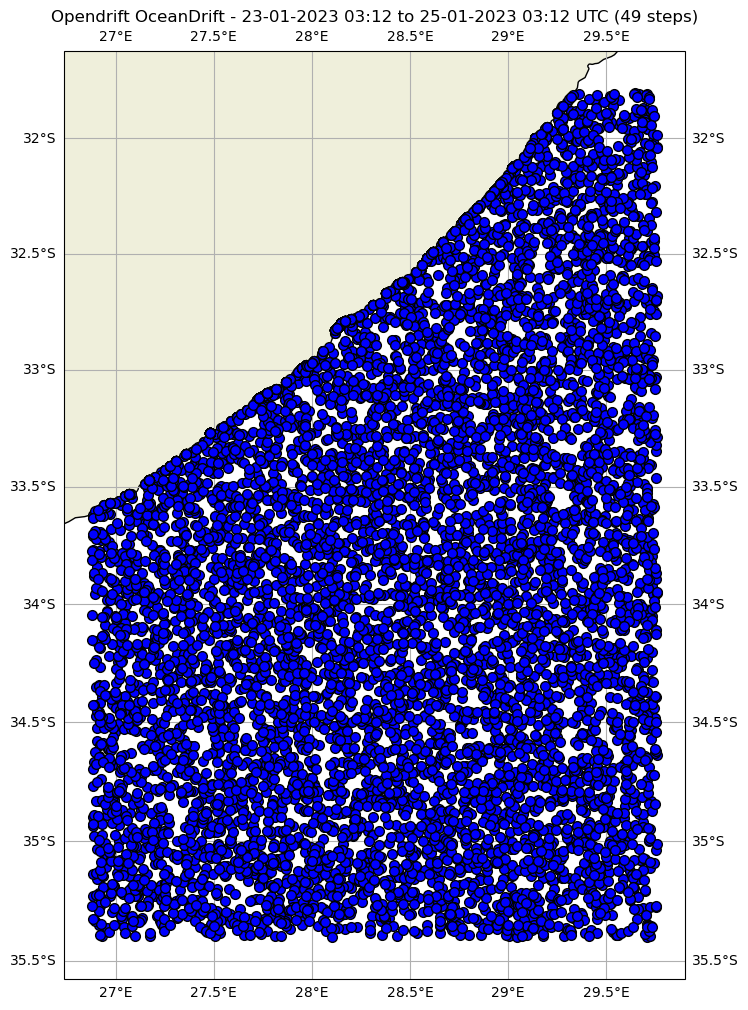

In [21]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.BORDERS)

#fwd.isel(time=0).traj.plot(linewidth=0.1)

for i in range(len(fwd.trajectory)):
    ax.plot(fwd.isel(trajectory=i).isel(time=0).lon.values, fwd.isel(trajectory=i).isel(time=0).lat.values, 'bo', mec='black', markersize=7, transform=ccrs.Geodetic())


#back.traj.plot(linewidth=0.1,color='red')

#d03.sel(time=slice('2023-01-25 03:12:08', '2023-01-27 03:12:08')).traj.plot(color='black')  

plt.gca().autoscale()
plt.title('Opendrift OceanDrift - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
plt.show() 

17:05:55 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=True, lscale=None
17:05:56 WARNING opendrift.models.basemodel:2379: Plotting fast. This will make your plots less accurate.
17:06:01 DEBUG   opendrift.models.basemodel:3020: Showing animation..


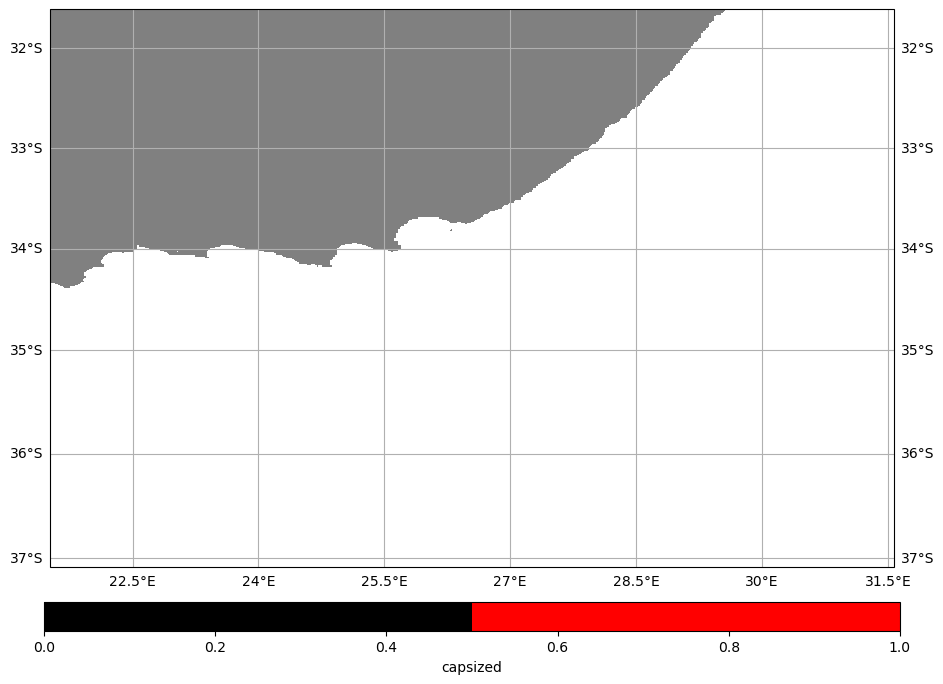

17:06:03 INFO    opendrift.models.basemodel:3003: Time to make animation: 0:00:07.121665


In [22]:
from matplotlib.colors import ListedColormap
ofwd.animation(color='capsized', cmap=ListedColormap(['black','red']), fast=True)

In [69]:
capsized = []
for i in range(len(fwd.trajectory)):
    capsized.append(fwd.isel(trajectory=i).capsized.values[-1])

In [71]:
len(capsized)

9600

In [72]:
np.count_nonzero(capsized)

6541

In [84]:
ilat = d03.lat.sel(time=slice(datetime(2023, 1, 15, 3, 12, 8), datetime(2023, 1, 15, 4, 12, 8))).values
ilon = d03.lon.sel(time=slice(datetime(2023, 1, 15, 3, 12, 8), datetime(2023, 1, 15, 4, 12, 8))).values

In [86]:
ilat

array([-35.35413637])

In [88]:
## FORWARD ## 
lon0 = []
lat0 = []
lonend0 = []
latend0 = []
for j in range(len(fwd.trajectory)):
        ### calculating hits ###
        lon0.append(fwd.isel(trajectory=j).lon.values)
        lat0.append(fwd.isel(trajectory=j).lat.values)
        lonend0.append(fwd.isel(trajectory=j).lon.values[-1])   # lon at end of trajectory
        latend0.append(fwd.isel(trajectory=j).lat.values[-1])   # lat at end of trajectory

In [89]:
geod = pyproj.Geod(ellps='WGS84')
on = np.ones(len(lonend0))
dummy1, dummy2, dist2incident = geod.inv(lonend0, latend0, ilon*on, ilat*on)
hits = np.where(dist2incident<10000)

hit_start_lons0= []
hit_start_lats0= []
for m in range(len(hits)):
        hit_start_lons0.append(lon0[hits[0][m]][0])
        hit_start_lats0.append(lat0[hits[0][m]][0])

In [202]:
fwd.capsized

<xarray.DataArray 'capsized' (trajectory: 9600, time: 121)> Size: 5MB
[1161600 values with dtype=float32]
Coordinates:
  * trajectory  (trajectory) int32 38kB 1 2 3 4 5 6 ... 9596 9597 9598 9599 9600
  * time        (time) datetime64[ns] 968B 2023-01-10T03:12:08 ... 2023-01-15...
Attributes:
    units:        1
    description:  0 is not capsized, changed to 1 after capsizing (irreversib...
    minval:       0
    maxval:       1

In [ ]:
for i in range(len(fwd.trajectory)):
    for j in range(len(fwd.time)):
        if fwd.isel(trajectory=i).isel(time=j).capsized>0:
            fwd.isel(trajectory=i).isel(time=j).traj.plot(color='blue', marker='o')
        else:
            fwd.isel(trajectory=i).isel(time=j).traj.plot(color='lightblue', marker='o')

No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimen

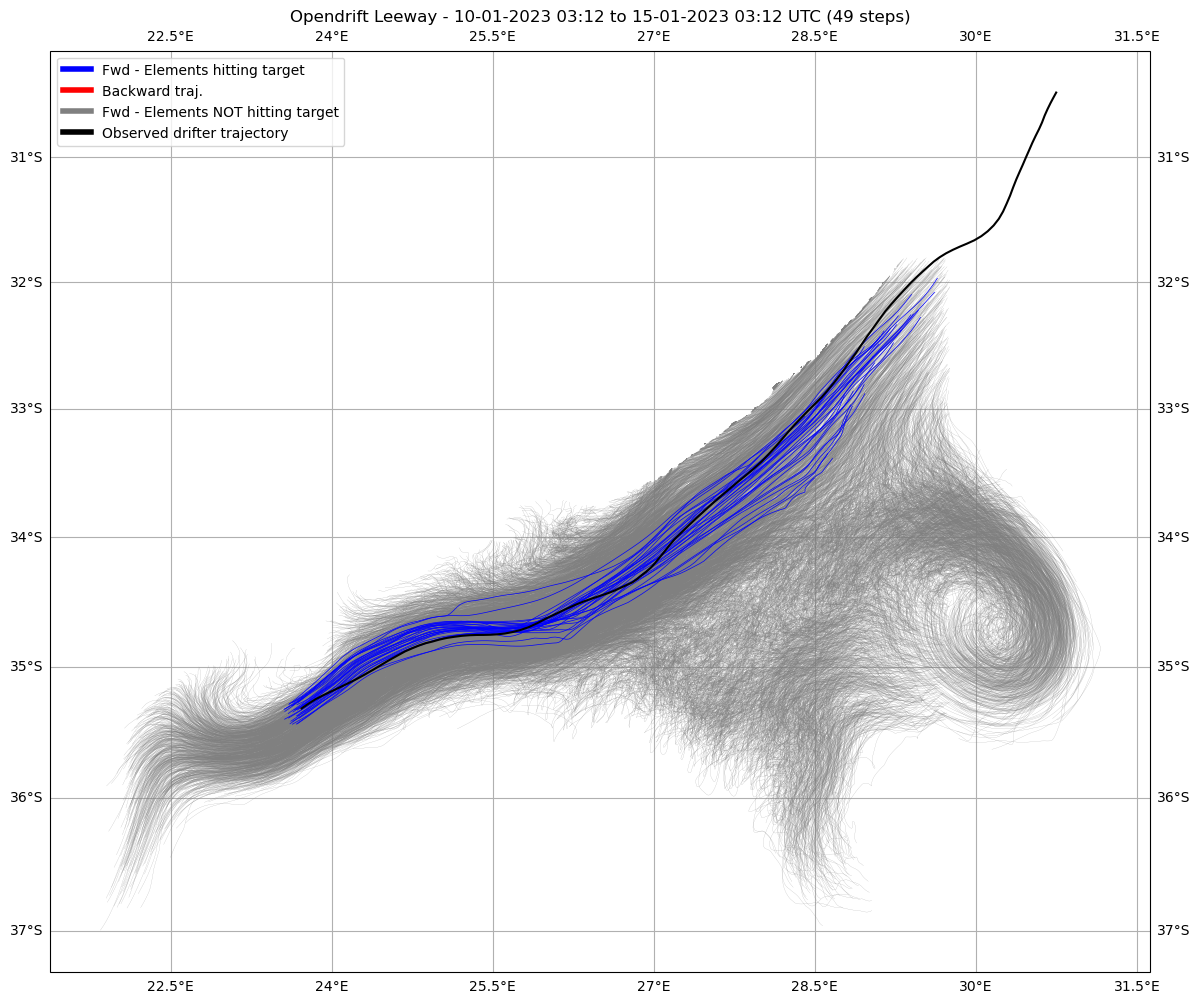

In [90]:
### PLOT ### 
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(fwd.trajectory)):
    fwd.isel(trajectory=i).traj.plot(linewidth=0.1)
    
for i in hits: 
    fwd.isel(trajectory=i).traj.plot(linewidth=0.5, color='blue')
#     ax.plot(fwd.isel(trajectory=i).isel(time=48).lon.values, fwd.isel(trajectory=i).isel(time=48).lat.values, 'bo', mec='black', markersize=7, transform=ccrs.Geodetic())
#     ax.plot(fwd.isel(trajectory=i).isel(time=0).lon.values, fwd.isel(trajectory=i).isel(time=0).lat.values, 'bo', mec='black', markersize=7, transform=ccrs.Geodetic())

# for i in range(len(fwd.trajectory)):
#     fwd.isel(trajectory=i).traj.plot(linewidth=0.5, color='red')
#     ax.plot(fwd.isel(trajectory=i).isel(time=48).lon.values, fwd.isel(trajectory=i).isel(time=48).lat.values, 'ro', mec='black', markersize=7, transform=ccrs.Geodetic())

d03.sel(time=slice('2023-01-10 03:12:08', '2023-01-15 03:12:08')).traj.plot(color='black')  

custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='black', lw=4)]

ax.legend(custom_lines, ['Fwd - Elements hitting target','Backward traj.', 'Fwd - Elements NOT hitting target', 'Observed drifter trajectory'])

plt.gca().autoscale()
plt.title('Opendrift Leeway - 10-01-2023 03:12 to 15-01-2023 03:12 UTC (49 steps)')
plt.show()

In [94]:
len(hits[0])

30

In [95]:
o_hit = opendrift.open(outfile, elements=hits[0])

10:52:08 DEBUG   opendrift.config:161: Adding 10 config items from environment
10:52:08 DEBUG   opendrift.config:161: Adding 5 config items from environment
10:52:08 DEBUG   opendrift.config:161: Adding 16 config items from __init__
10:52:08 DEBUG   opendrift.config:171:   Overwriting config item readers:max_number_of_fails
10:52:08 DEBUG   opendrift.config:161: Adding 5 config items from __init__
10:52:08 INFO    opendrift.models.basemodel:533: OpenDriftSimulation initialised (version 1.11.2 / v1.11.2-43-gce9f6bb)
10:52:08 DEBUG   opendrift.config:161: Adding 6 config items from leeway
10:52:08 DEBUG   opendrift.config:171:   Overwriting config item seed:jibe_probability
10:52:08 DEBUG   opendrift.export.io_netcdf:281: Importing from D:/backtrack/oceandrift_48h/likelihood/lw_fwd1015jan_nodif_raft_capsize20.nc
10:52:08 DEBUG   opendrift.models.basemodel:1683: No elements to deactivate
10:52:08 DEBUG   opendrift.export.io_netcdf:380: Setting imported config: environment:constant:x_wind 

10:52:10 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=False, lscale=None
10:52:10 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (23.155109024047857, 30.041281127929686, -35.64029617309571, -31.769402313232426)..
10:52:16 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (23.155109024047857, 30.041281127929686, -35.64029617309571, -31.769402313232426)..
10:52:17 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (23.155109024047857, 30.041281127929686, -35.64029617309571, -31.769402313232426)..


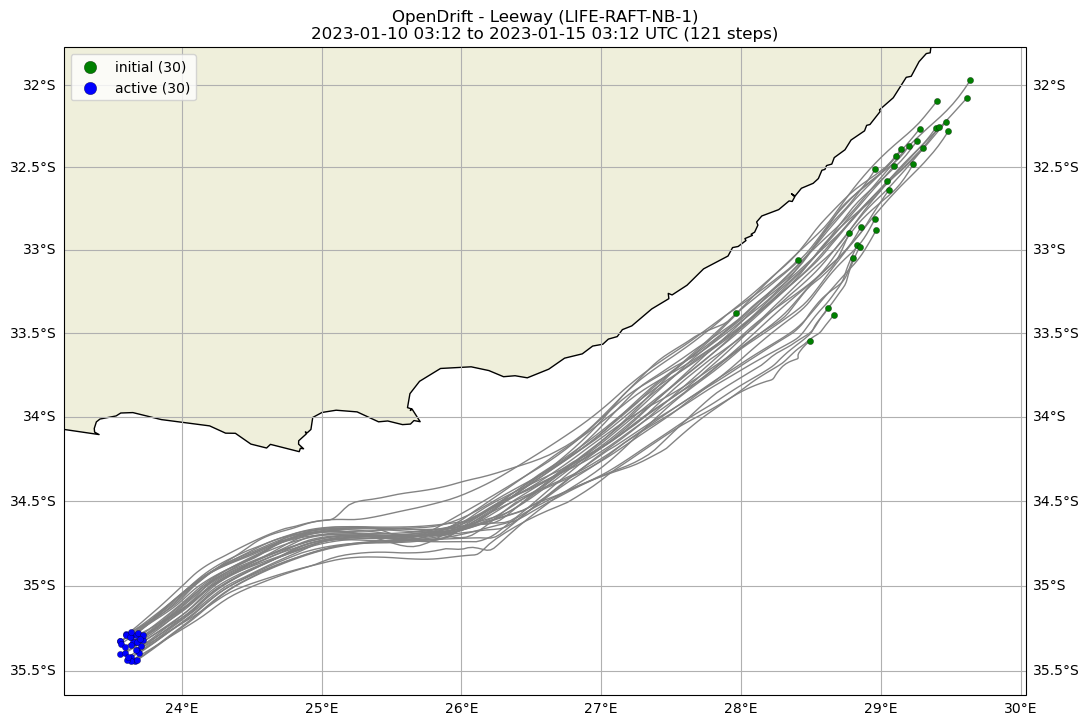

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-01-10 03:12 to 2023-01-15 03:12 UTC (121 steps)'}>,
 <Figure size 1100x743.278 with 1 Axes>)

In [96]:
o_hit.plot()

10:52:28 DEBUG   opendrift.config:161: Adding 10 config items from environment
10:52:28 DEBUG   opendrift.config:161: Adding 5 config items from environment
10:52:28 DEBUG   opendrift.config:161: Adding 16 config items from __init__
10:52:28 DEBUG   opendrift.config:171:   Overwriting config item readers:max_number_of_fails
10:52:28 DEBUG   opendrift.config:161: Adding 5 config items from __init__
10:52:28 INFO    opendrift.models.basemodel:533: OpenDriftSimulation initialised (version 1.11.2 / v1.11.2-43-gce9f6bb)
10:52:28 DEBUG   opendrift.config:161: Adding 6 config items from leeway
10:52:28 DEBUG   opendrift.config:171:   Overwriting config item seed:jibe_probability
10:52:28 DEBUG   opendrift.export.io_netcdf:226: Importing with Xarray from D:/backtrack/oceandrift_48h/likelihood/lw_fwd1015jan_nodif_raft_capsize20.nc
10:52:28 INFO    opendrift:118: Returning <class 'opendrift.models.leeway.Leeway'> object
10:52:28 INFO    opendrift.models.basemodel:3854: 	calculating for origin_ma

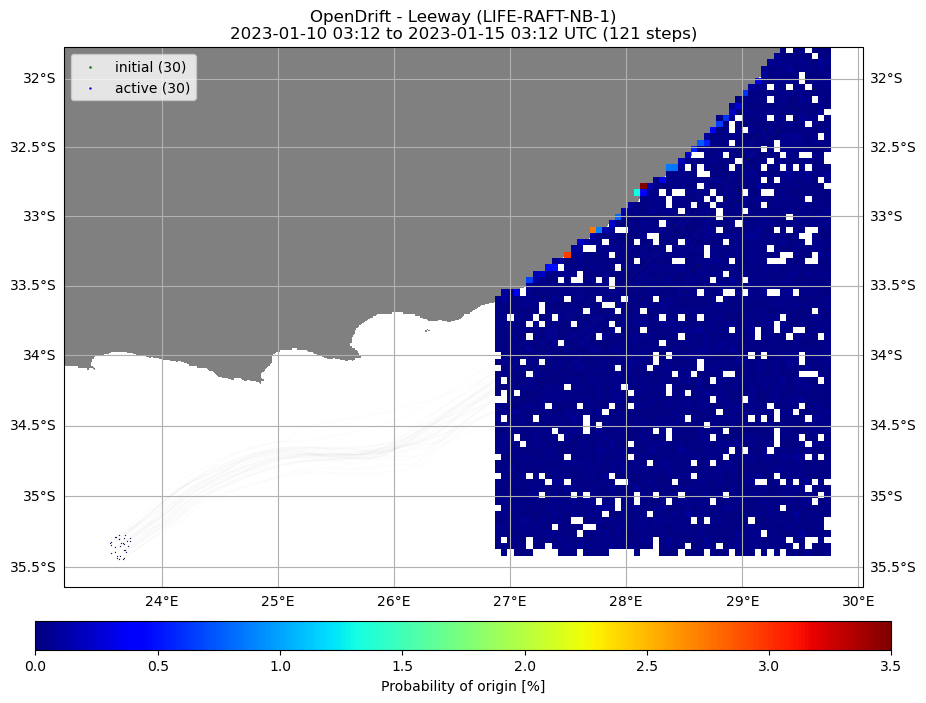

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-01-10 03:12 to 2023-01-15 03:12 UTC (121 steps)'}>,
 <Figure size 1100x743.278 with 2 Axes>)

In [97]:
of = opendrift.open_xarray(outfile)
density_fwd = of.get_histogram(pixelsize_m=5000).isel(time=0).isel(origin_marker=0)
density_fwd = density_fwd.where(density_fwd>0)
density_fwd = density_fwd/density_fwd.sum()*100
vmax = density_fwd.max()
o_hit.plot(background=density_fwd, clabel='Probability of origin [%]', fast=True, markersize=.5, lalpha=.02, vmin=0)

In [98]:
# lonbin = np.arange(np.min(back.isel(time=48).lon.values)-(0.5), np.max(back.isel(time=48).lon.values)+(0.5), 0.025)
# latbin = np.arange(np.min(back.isel(time=48).lat.values)-(0.5), np.max(back.isel(time=48).lat.values)+(0.5), 0.025)

In [99]:
fwd = xr.open_dataset(outfile)

In [100]:
xfwd = fwd.isel(trajectory=hits[0])

#### Start lon and lat of FWD 'hits'

In [101]:
lon = []       # lon for 'hits'
lat = []       # lat for 'hits'

for i in range(len(xfwd.trajectory)):
    lon.append(xfwd.isel(trajectory=i).lon.values[0])
    lat.append(xfwd.isel(trajectory=i).lat.values[0])

#### Start lon and lat of all FWD runs

In [102]:
lonall = []
latall = []

for i in range(len(fwd.trajectory)):
    lonall.append(fwd.isel(trajectory=i).lon.values[0])
    latall.append(fwd.isel(trajectory=i).lat.values[0])

In [103]:
# Set the desired grid size
# grid_size_lon = 0.120  # Change this to your desired grid size
# grid_size_lat = 0.100

# # Calculate the number of grid cells in each dimension
# lon_bins = np.arange(np.min(lonall), np.max(lonall) + grid_size_lon, grid_size_lon)
# lat_bins = np.arange(np.min(latall), np.max(latall) + grid_size_lat, grid_size_lat)

# Calculate the number of grid cells in each dimension
# lon_bins = np.arange(np.min(back.isel(time=48).lon.values)-(0.5), np.max(back.isel(time=48).lon.values)+(0.5), grid_size_lon)
# lat_bins = np.arange(np.min(back.isel(time=48).lat.values)-(0.5), np.max(back.isel(time=48).lat.values)+(0.5), grid_size_lat)

In [104]:
def count_points_in_grid(lon, lat, lonbins, latbins):
    
    lobi = []
    labi = []
    for i in range(len(lonbins)-1):
        lobi.append((lonbins[i]+lonbins[i+1])/2)
    for i in range(len(latbins)-1):
        labi.append((latbins[i]+latbins[i+1])/2)
        
    # Count the number of points in each grid cell
    counts, xedges, yedges = np.histogram2d(lon, lat, bins=[lonbins, latbins])
    
    # Create a new DataArray with the counts and assign coordinates
    counts_dataarray = xr.DataArray(counts, coords=[('lon_bin', lobi), ('lat_bin', labi)])
    
    return counts_dataarray 

# Call the function to count points in grid cells
grid_counts = count_points_in_grid(lon, lat, lon_bins, lat_bins)

10:54:28 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=True, lscale=None
10:54:28 WARNING opendrift.models.basemodel:2379: Plotting fast. This will make your plots less accurate.


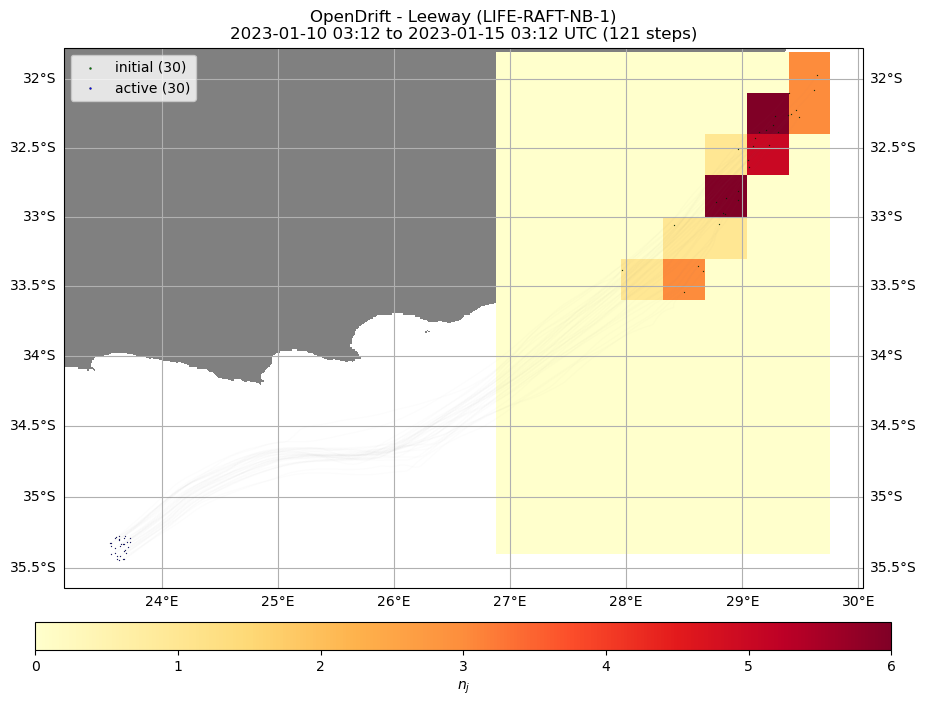

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-01-10 03:12 to 2023-01-15 03:12 UTC (121 steps)'}>,
 <Figure size 1100x743.278 with 2 Axes>)

In [105]:
o_hit.plot(background=grid_counts, clabel='$n_j$', fast=True, markersize=.5, lalpha=.02, vmin=0, cmap='YlOrRd')

In [106]:
# Call the function to count points in grid cells
grid_counts_all = count_points_in_grid(lonall, latall, lon_bins, lat_bins)

10:54:52 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=True, lscale=None
10:54:52 WARNING opendrift.models.basemodel:2379: Plotting fast. This will make your plots less accurate.


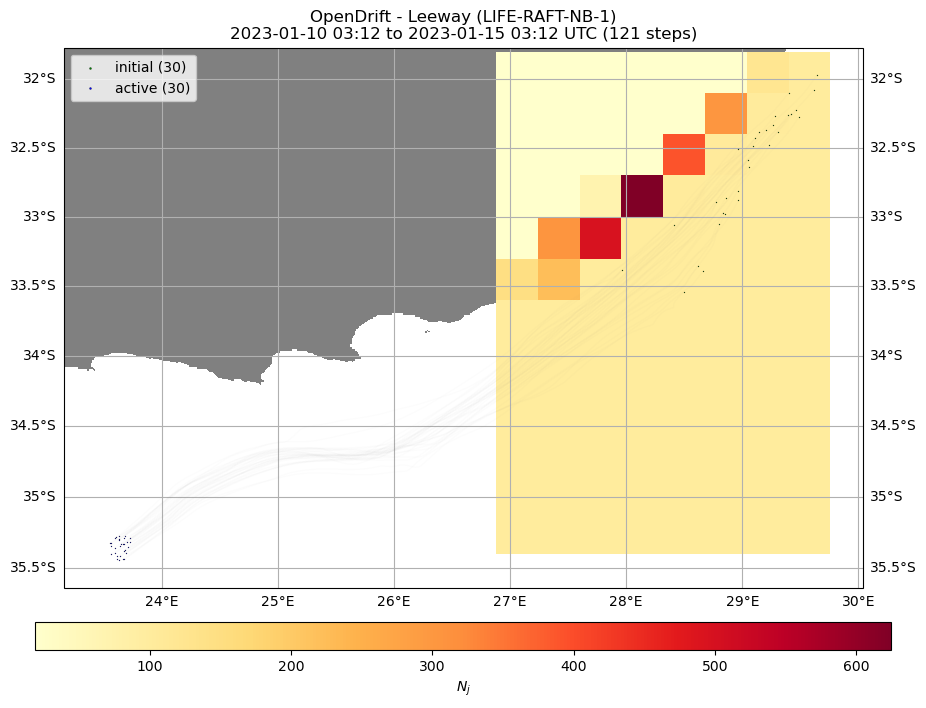

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-01-10 03:12 to 2023-01-15 03:12 UTC (121 steps)'}>,
 <Figure size 1100x743.278 with 2 Axes>)

In [107]:
o_hit.plot(background=grid_counts_all, clabel='$N_j$', fast=True, markersize=.5, lalpha=.02, vmin=19, cmap='YlOrRd')

10:54:56 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=True, lscale=None
10:54:56 WARNING opendrift.models.basemodel:2379: Plotting fast. This will make your plots less accurate.


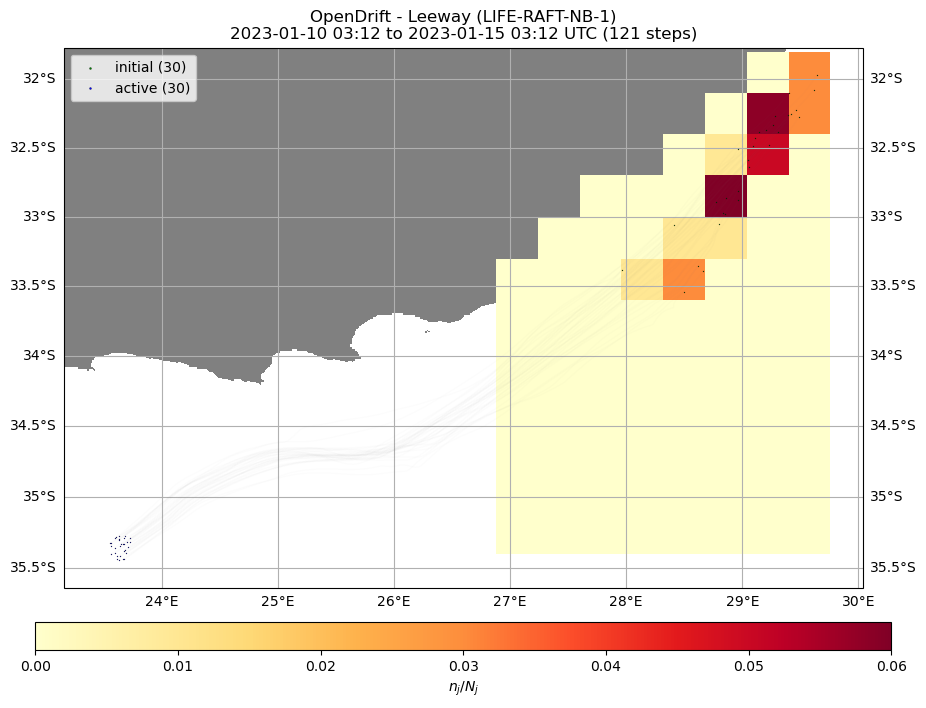

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-01-10 03:12 to 2023-01-15 03:12 UTC (121 steps)'}>,
 <Figure size 1100x743.278 with 2 Axes>)

In [108]:
o_hit.plot(background=grid_counts/grid_counts_all, clabel='$n_j / N_j$', fast=True, markersize=.5, lalpha=.02, vmin=0, cmap='YlOrRd')

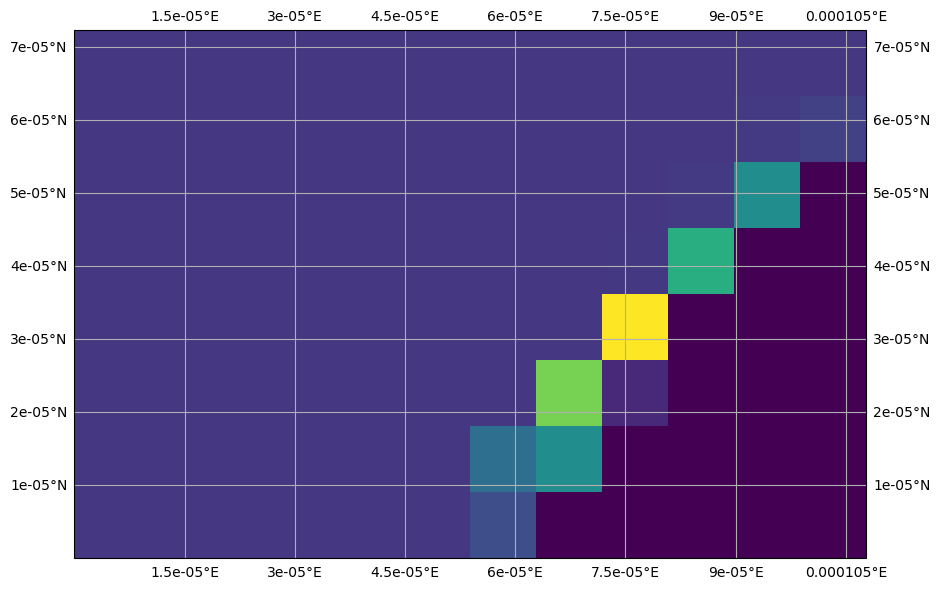

In [109]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)
ax.pcolormesh(grid_counts_all)

In [110]:
likelihood = grid_counts/grid_counts_all

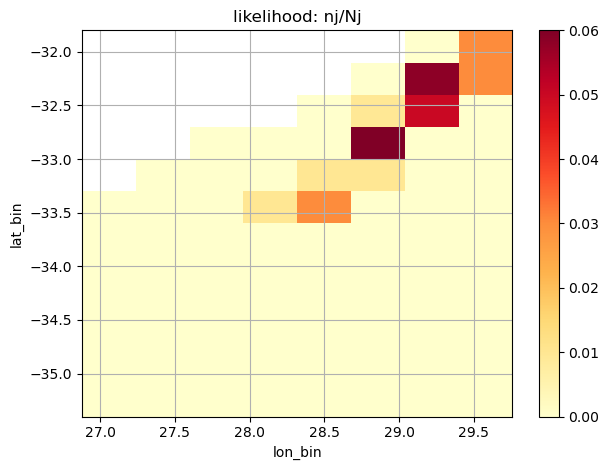

In [111]:
likelihood.plot(x=grid_counts.dims[0], y=grid_counts.dims[1], cmap='YlOrRd')
plt.title('likelihood: nj/Nj')
plt.grid()

### Equal Prior Probability

In [112]:
prior = grid_counts_all/len(fwd.trajectory)

### Variable Prior Probability

Variable prior by LATITUDE:

In [113]:
varprior1 = (grid_counts_all[:,0:3]-4)
varprior2 = (grid_counts_all[:,3:7]+7)
varprior3 = (grid_counts_all[:,7:11]-4)

In [114]:
varprior = xr.concat([varprior1, varprior2,varprior3], dim='lat_bin')/len(fwd.trajectory)

Variable prior by LONGITUDE:

In [115]:
len(grid_counts_all[10:19])

0

In [116]:
varprior1 = (grid_counts_all[0:10]+9) 
varprior2 = (grid_counts_all[10:19]-10)

In [117]:
varprior = xr.concat([varprior1, varprior2], dim='lon_bin')/len(fwd.trajectory)

Check if sum of all prior probabilities is 1!!!

In [118]:
np.sum(prior)

<xarray.DataArray ()> Size: 8B
array(1.)

In [119]:
np.sum(varprior)

<xarray.DataArray ()> Size: 8B
array(1.09)

### Posterior (and norm. const.)

In [120]:
norm_const = len(hits[0])/len(fwd.trajectory)
posterior = (likelihood*prior)/norm_const

In [121]:
norm_const = len(hits[0])/len(fwd.trajectory)
varposterior = (likelihood*varprior)/norm_const

In [122]:
np.sum(posterior)

<xarray.DataArray ()> Size: 8B
array(1.)

For equal prior: 

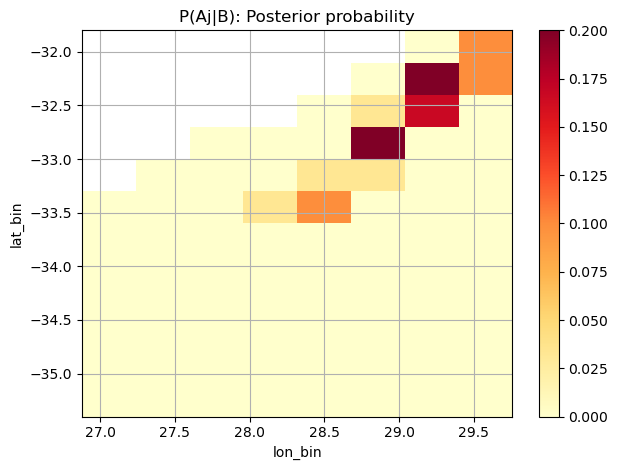

In [123]:
posterior.plot(x=posterior.dims[0], y=posterior.dims[1], cmap='YlOrRd')
plt.title('P(Aj|B): Posterior probability')
plt.grid()

For variable prior: 

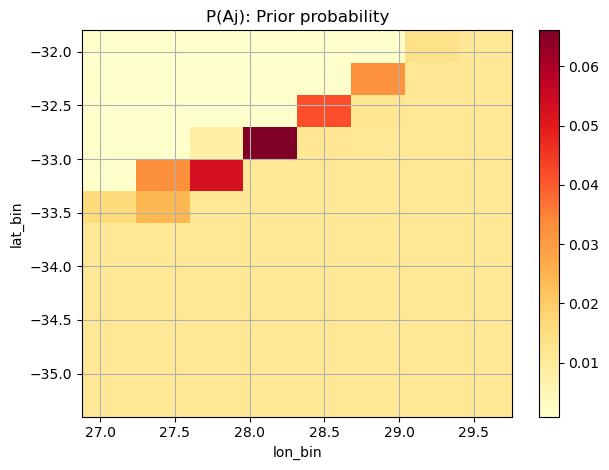

In [124]:
varprior.plot(x=varprior.dims[0], y=varprior.dims[1], cmap='YlOrRd')
plt.title('P(Aj): Prior probability')
plt.grid()

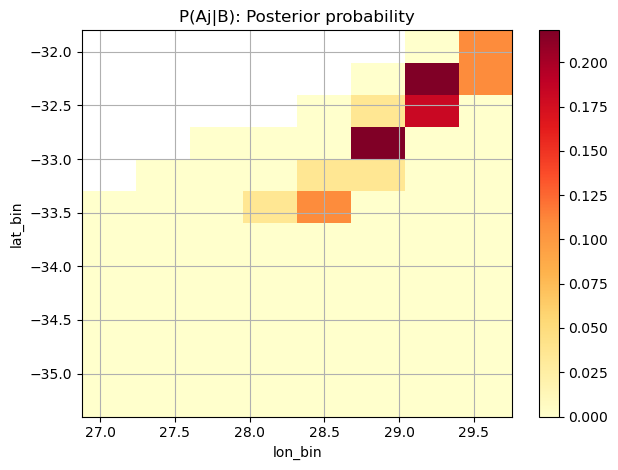

In [125]:
varposterior.plot(x=varposterior.dims[0], y=varposterior.dims[1], cmap='YlOrRd')
plt.title('P(Aj|B): Posterior probability')
plt.grid()

10:55:58 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=True, lscale=None
10:55:58 WARNING opendrift.models.basemodel:2379: Plotting fast. This will make your plots less accurate.


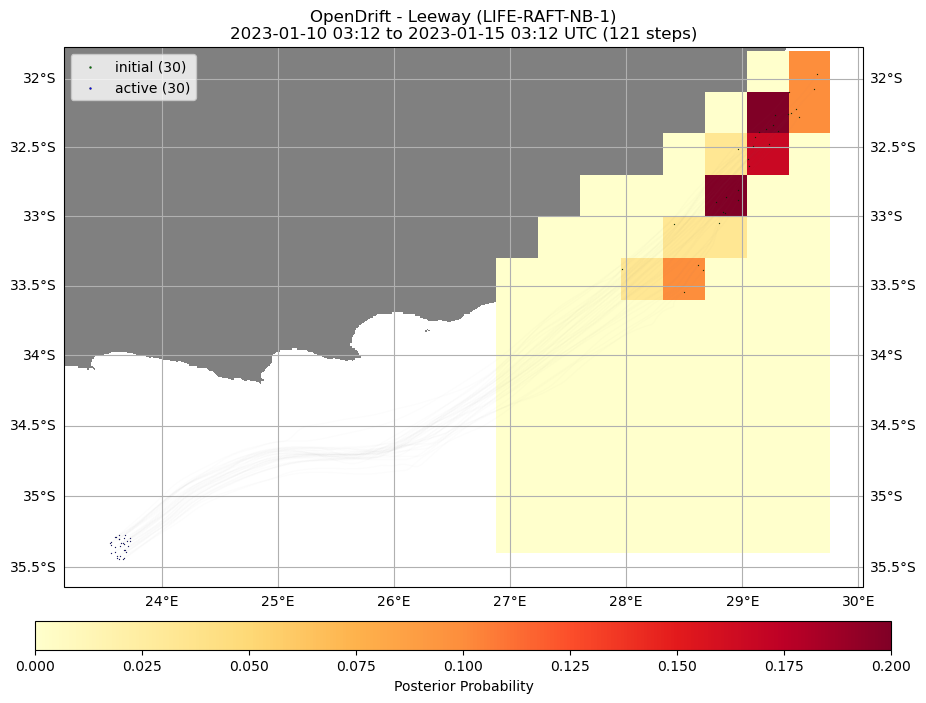

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-01-10 03:12 to 2023-01-15 03:12 UTC (121 steps)'}>,
 <Figure size 1100x743.278 with 2 Axes>)

In [126]:
o_hit.plot(posterior, clabel='Posterior Probability', fast=True, markersize=.5, lalpha=.02, vmin=0, cmap='YlOrRd')

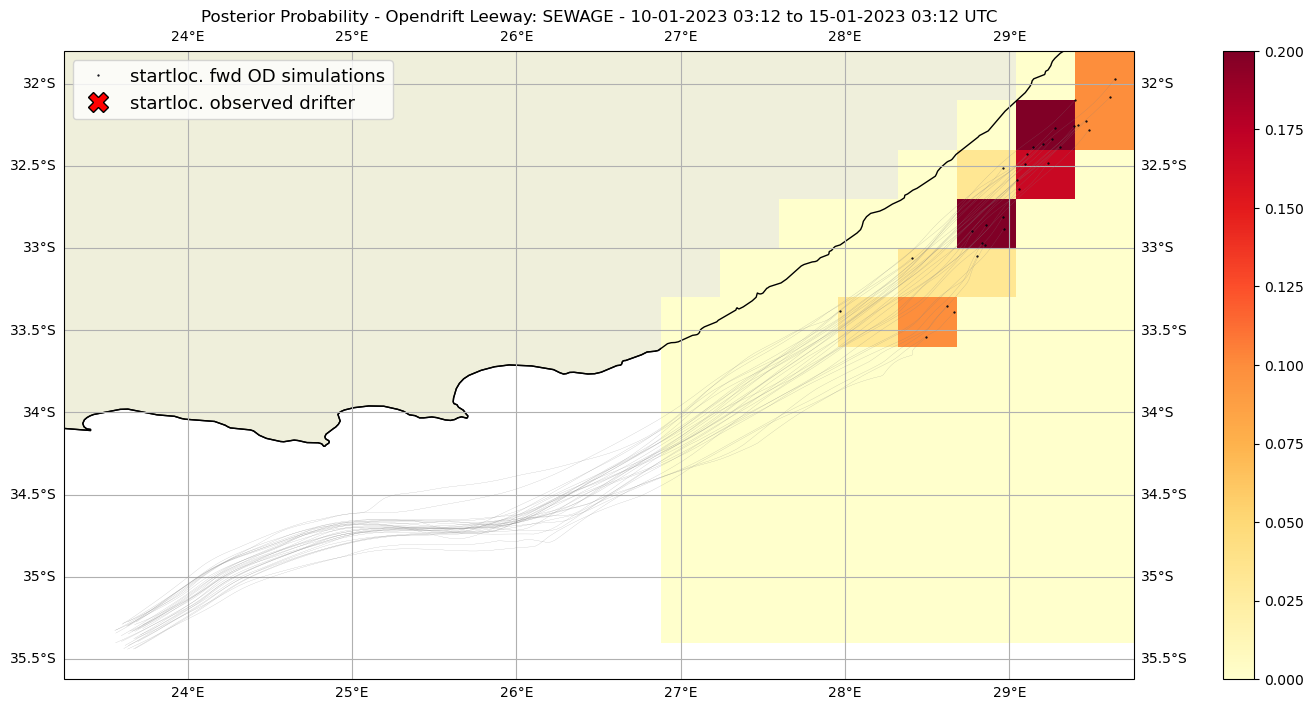

In [127]:
fig = plt.figure(1, figsize=(18,7))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([18, 22, -36, -39])

ax.gridlines(draw_labels=True)
ax.coastlines(facecolor='black')
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.BORDERS)


### Plotting simulations and drifter trajectories ### 

#posterior.plot.pcolormesh(x="lon_bin", y="lat_bin", ax=ax, cmap='YlOrRd', infer_intervals=True)

for i in hits: 
    fwd.isel(trajectory=i).traj.plot(linewidth=0.1, color='grey')
    ax.plot(fwd.isel(trajectory=i).isel(time=0).lon.values, fwd.isel(trajectory=i).isel(time=0).lat.values, 'bo', mec='black', markersize=0.6, transform=ccrs.PlateCarree(), label='startloc. fwd OD simulations')

ax.plot(d03.sel(time=slice('2023-01-10 03:12:08', '2023-01-10 03:12:08')).lon.values, d03.sel(time=slice('2023-01-10 03:12:08', '2023-01-10 03:12:08')).lat.values, 'X', color='red', mec='black', markersize=14, transform=ccrs.PlateCarree(), label='startloc. observed drifter')  

post = posterior.plot.pcolormesh(x="lon_bin", y="lat_bin", ax=ax, cmap='YlOrRd', label='Posterior probability')
#fig.colorbar(post, ax=ax, location='right', label='Posterior')

plt.legend(fontsize=13)
plt.gca().autoscale()
plt.title('Posterior Probability - Opendrift Leeway: SEWAGE - 10-01-2023 03:12 to 15-01-2023 03:12 UTC', fontsize=12)
plt.show() 

# BACKWARDS

In [152]:
outfile_bwd = "D:/backtrack/oceandrift_48h/likelihood/lw_bwd1015jan_nodif_sailb39.nc"
back_capsize = xr.open_dataset(outfile_bwd)

In [153]:
lonback = []       # lon for bwd
latback = []       # lat for bwd

for i in range(len(back_capsize.trajectory)):
    lonback.append(back_capsize.isel(trajectory=i).lon.values[-1])
    latback.append(back_capsize.isel(trajectory=i).lat.values[-1])

In [154]:
grid_counts_back = count_points_in_grid(lonback, latback, lon_bins, lat_bins)

In [155]:
o_back = opendrift.open(outfile_bwd)

11:22:23 DEBUG   opendrift.config:161: Adding 16 config items from __init__
11:22:23 DEBUG   opendrift.config:171:   Overwriting config item readers:max_number_of_fails
11:22:23 DEBUG   opendrift.config:161: Adding 5 config items from __init__
11:22:23 INFO    opendrift.models.basemodel:533: OpenDriftSimulation initialised (version 1.11.2 / v1.11.2-43-gce9f6bb)
11:22:23 DEBUG   opendrift.config:161: Adding 6 config items from leeway
11:22:23 DEBUG   opendrift.config:171:   Overwriting config item seed:jibe_probability
11:22:23 DEBUG   opendrift.export.io_netcdf:281: Importing from D:/backtrack/oceandrift_48h/likelihood/lw_bwd1015jan_nodif_sailb39.nc
11:22:23 DEBUG   opendrift.models.basemodel:1687: Removed 2 elements.
11:22:23 DEBUG   opendrift.export.io_netcdf:380: Setting imported config: general:use_auto_landmask -> True
11:22:23 DEBUG   opendrift.export.io_netcdf:380: Setting imported config: general:coastline_action -> stranding
11:22:23 DEBUG   opendrift.export.io_netcdf:380: Set

11:22:28 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=True, lscale=None
11:22:28 WARNING opendrift.models.basemodel:2379: Plotting fast. This will make your plots less accurate.


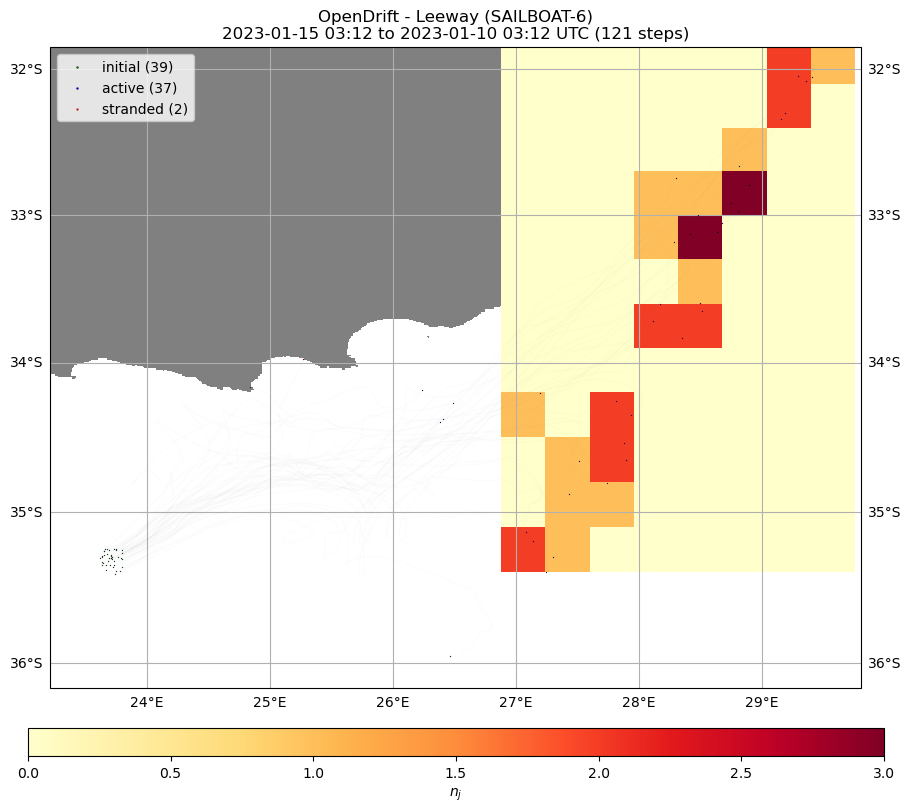

(<GeoAxes: title={'center': 'OpenDrift - Leeway (SAILBOAT-6)\n2023-01-15 03:12 to 2023-01-10 03:12 UTC (121 steps)'}>,
 <Figure size 1100x868.828 with 2 Axes>)

In [156]:
o_back.plot(background=grid_counts_back, clabel='$n_j$', fast=True, markersize=.5, lalpha=.02, vmin=0, cmap='YlOrRd')

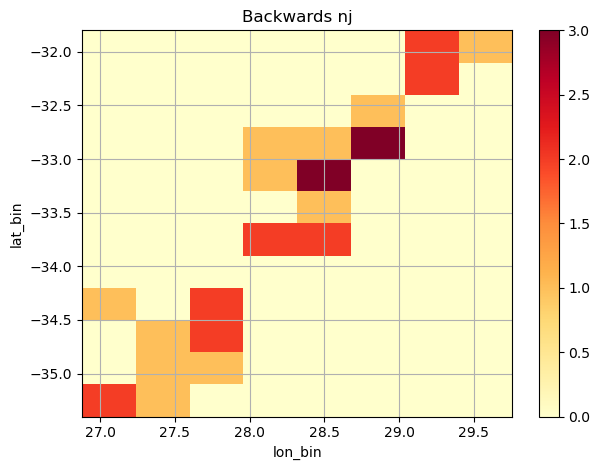

In [157]:
grid_counts_back.plot(x=grid_counts_back.dims[0], y=grid_counts_back.dims[1], cmap='YlOrRd')
plt.title('Backwards nj')
plt.grid()

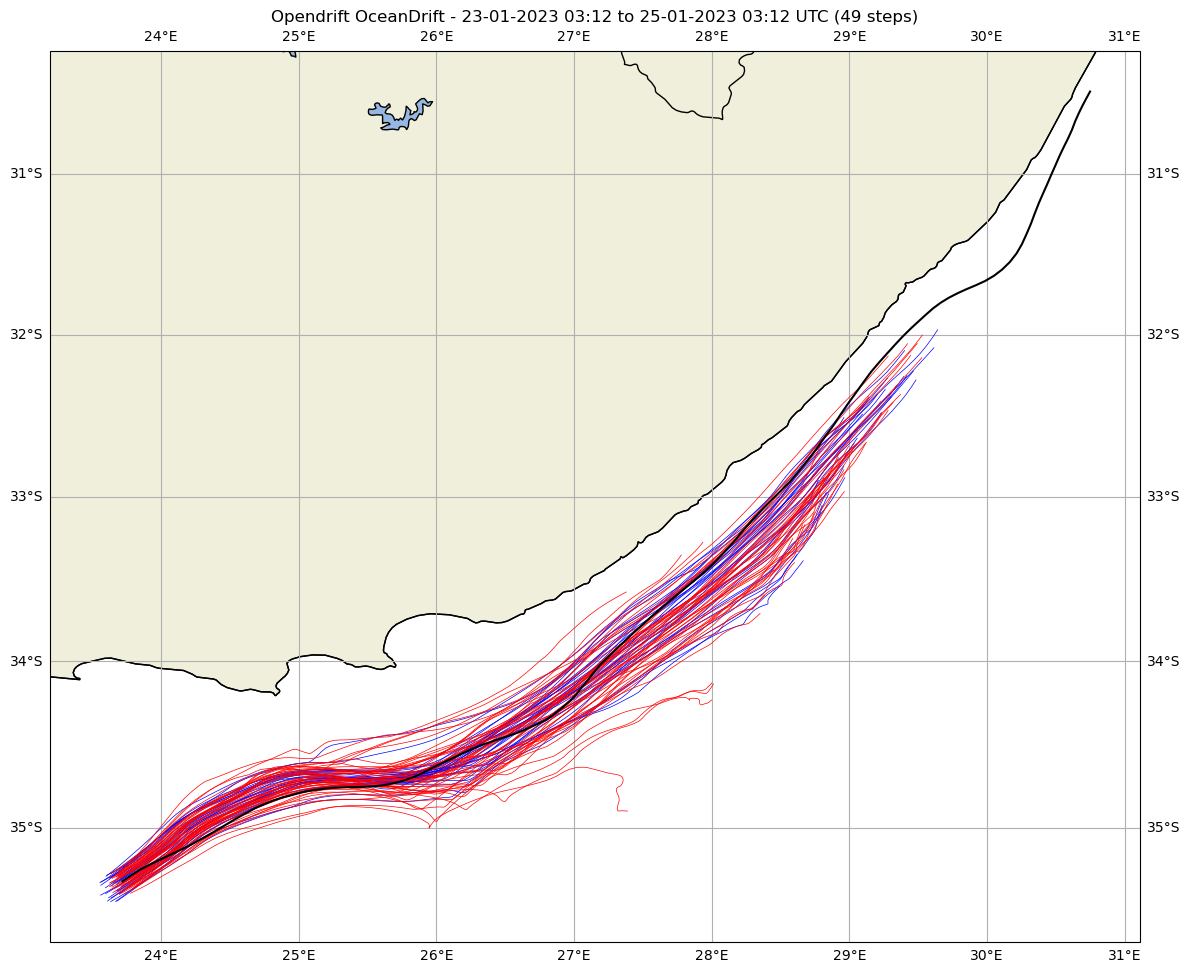

In [158]:
fig = plt.figure(1, figsize=(12,10))
ax = fig.add_subplot(111, projection=ccrs.Mercator())
ax.set_extent([18, 22, -36, -39])

ax.gridlines(draw_labels=True)
ax.coastlines(facecolor='black')
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.BORDERS)


### Plotting simulations and drifter trajectories ### 

for i in hits: 
    fwd.isel(trajectory=i).traj.plot(linewidth=0.5, color='blue')

back.traj.plot(linewidth=0.5,color='red')

# ax.plot(back192.isel(time=0).lon.values, back192.isel(time=0).lat.values, 'ro', markersize=0.5, transform=ccrs.Geodetic())
# for i in hits: 
#     ax.plot(fwd.isel(trajectory=i).isel(time=48).lon.values, fwd.isel(trajectory=i).isel(time=48).lat.values, 'bo', markersize=0.5, transform=ccrs.Geodetic())

d03.sel(time=slice('2023-01-10 03:12:08', '2023-01-15 03:12:08')).traj.plot(color='black')  

plt.gca().autoscale()
plt.title('Opendrift OceanDrift - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
plt.show() 

11:22:37 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=True, lscale=None
11:22:37 WARNING opendrift.models.basemodel:2379: Plotting fast. This will make your plots less accurate.


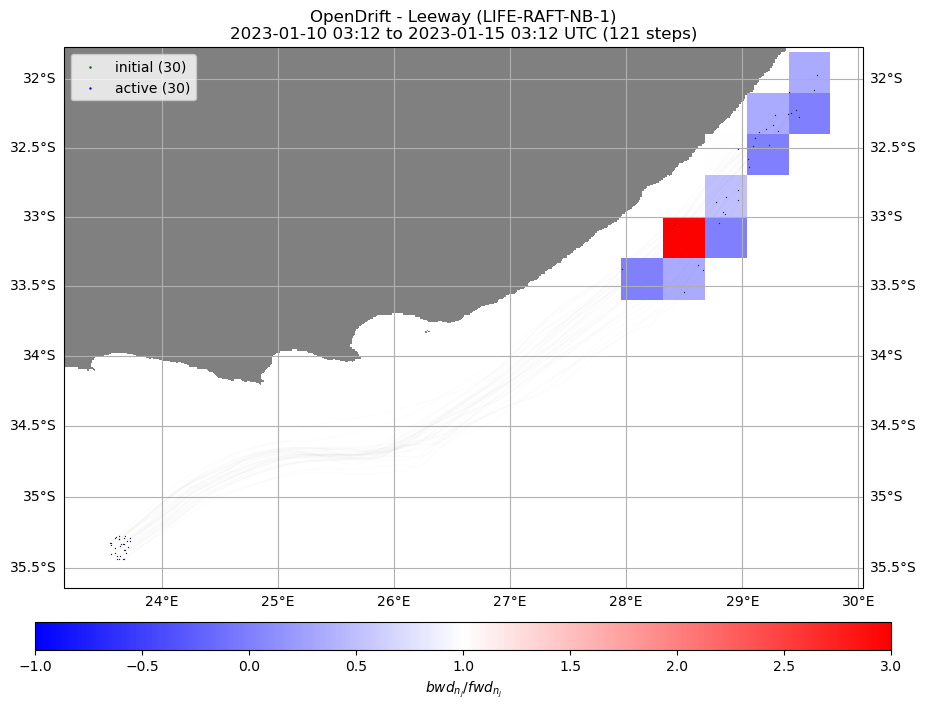

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-01-10 03:12 to 2023-01-15 03:12 UTC (121 steps)'}>,
 <Figure size 1100x743.278 with 2 Axes>)

In [159]:
o_hit.plot(background=grid_counts_back/grid_counts, clabel='$bwd_{n_j} / fwd_{n_j}$', cmap='bwr', fast=True, markersize=.5, lalpha=.02, vmin=-1, vmax=3)

11:22:41 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=True, lscale=None
11:22:41 WARNING opendrift.models.basemodel:2379: Plotting fast. This will make your plots less accurate.


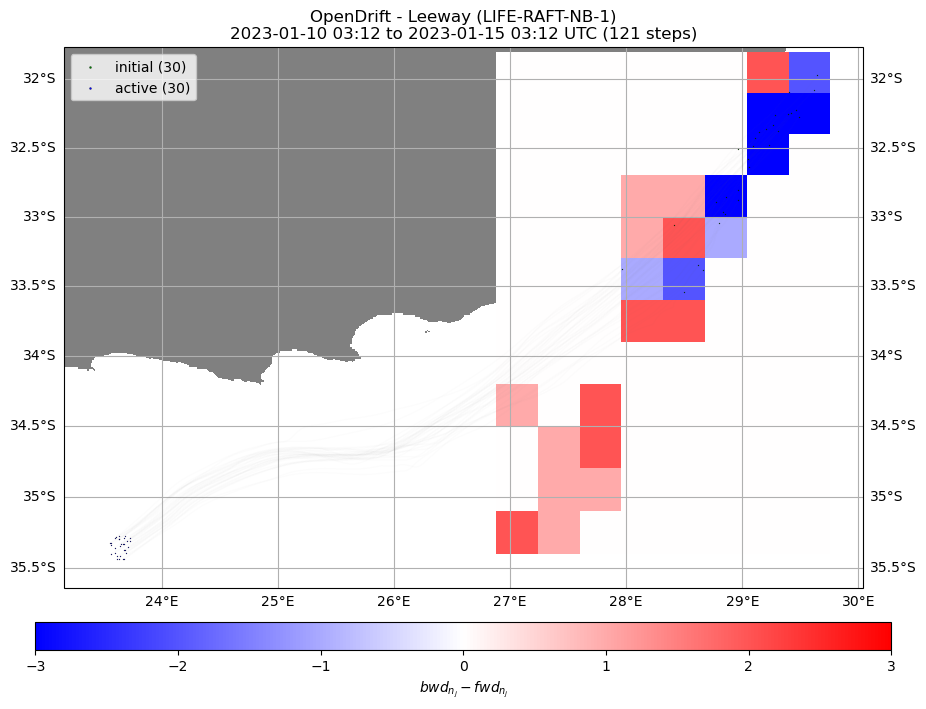

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-01-10 03:12 to 2023-01-15 03:12 UTC (121 steps)'}>,
 <Figure size 1100x743.278 with 2 Axes>)

In [160]:
o_hit.plot(background=grid_counts_back-grid_counts, clabel='$bwd_{n_j} - fwd_{n_j}$', cmap='bwr', fast=True, markersize=.5, lalpha=.02, vmin=-3, vmax=3)

In [162]:
back_capsize

<xarray.Dataset> Size: 393kB
Dimensions:               (trajectory: 39, time: 121)
Coordinates:
  * trajectory            (trajectory) int32 156B 1 2 3 4 5 6 ... 35 36 37 38 39
  * time                  (time) datetime64[ns] 968B 2023-01-15T03:12:08 ... ...
Data variables: (12/22)
    status                (trajectory, time) int32 19kB ...
    moving                (trajectory, time) int32 19kB ...
    age_seconds           (trajectory, time) float32 19kB ...
    origin_marker         (trajectory, time) int32 19kB ...
    lon                   (trajectory, time) float32 19kB ...
    lat                   (trajectory, time) float32 19kB ...
    ...                    ...
    current_drift_factor  (trajectory, time) float32 19kB ...
    x_wind                (trajectory, time) float32 19kB ...
    y_wind                (trajectory, time) float32 19kB ...
    x_sea_water_velocity  (trajectory, time) float32 19kB ...
    y_sea_water_velocity  (trajectory, time) float32 19kB ...
    land_binary_mask      (trajectory, time) float32 19kB ...
Attributes: (12/64)
    Conventions:                                       CF-1.6
    standard_name_vocabulary:                          CF-1.6
    featureType:                                       trajectory
    history:                                           Created 2024-04-05 16:...
    source:                                            Output from simulation...
    model_url:                                         https://github.com/Ope...
    ...                                                ...
    geospatial_lat_resolution:                         point
    geospatial_lon_min:                                0.0
    geospatial_lon_max:                                0.0
    geospatial_lon_units:                              degrees_east
    geospatial_lon_resolution:                         point
    runtime:                                           0:00:10.856129

In [ ]:
back_capsize2.capsized[-1]

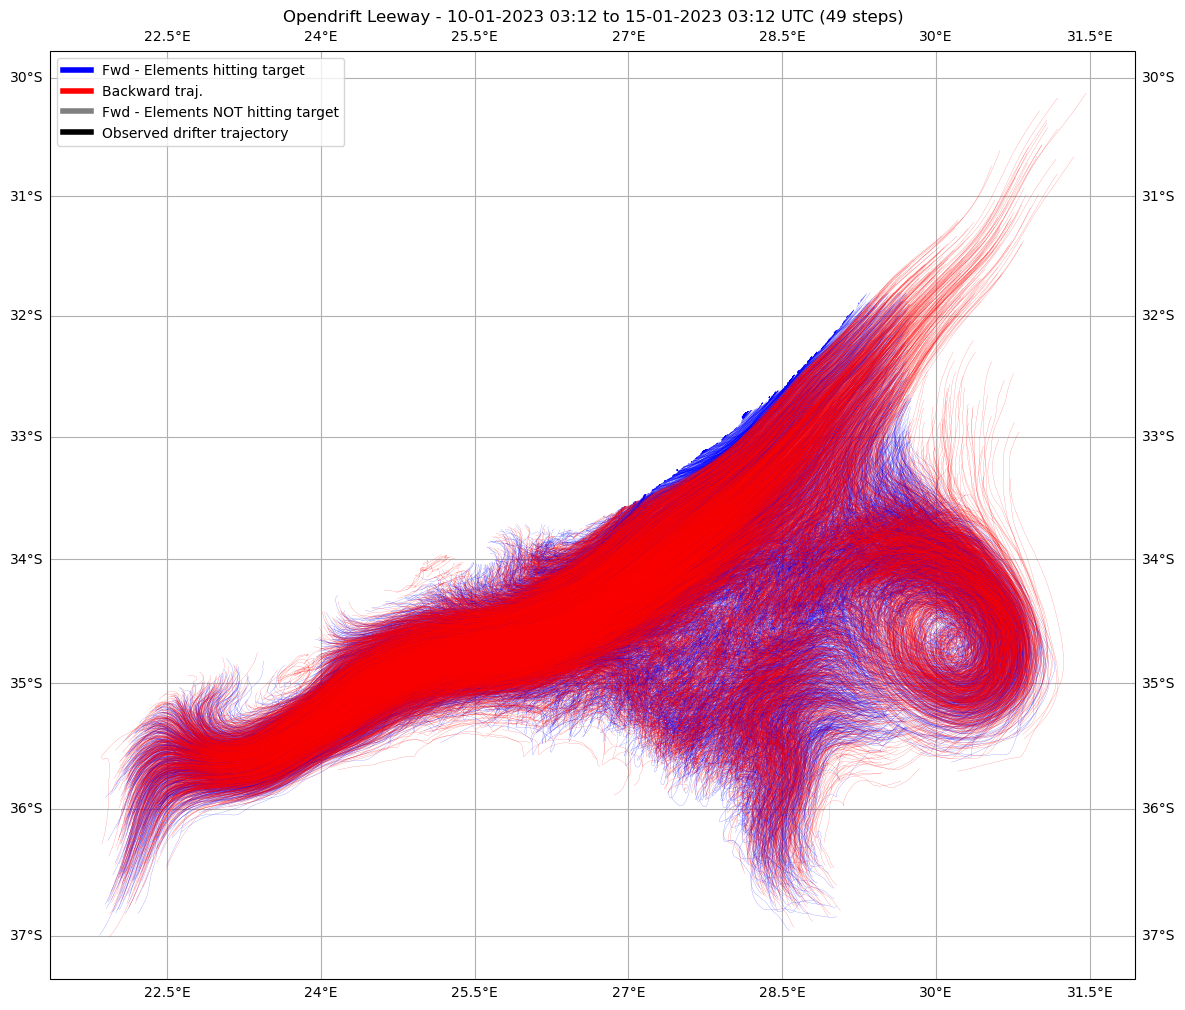

In [191]:
### PLOT ### 
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(fwd.trajectory)):
    fwd.isel(trajectory=i).traj.plot(linewidth=0.1, color='blue')

for i in range(len(back_capsize2.trajectory)):
    back_capsize2.isel(trajectory=i).traj.plot(linewidth=0.1, color='red') 
    

#d03.sel(time=slice('2023-01-10 03:12:08', '2023-01-15 03:12:08')).traj.plot(color='black')  

custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='black', lw=4)]

ax.legend(custom_lines, ['Fwd - Elements hitting target','Backward traj.', 'Fwd - Elements NOT hitting target', 'Observed drifter trajectory'])

plt.gca().autoscale()
plt.title('Opendrift Leeway - 10-01-2023 03:12 to 15-01-2023 03:12 UTC (49 steps)')
plt.show()